In [ ]:
import numpy as np
import pandas as pd
from itertools import product
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    label_binarize)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    log_loss,
    average_precision_score,
    roc_curve,
    precision_recall_curve)
from sklearn.calibration import calibration_curve


In [17]:
# loading the data
df = pd.read_csv("loan.csv")
df.shape
df_raw = df.copy()

C:\Users\tamar\AppData\Local\Temp\ipykernel_35704\961585608.py:2: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan.csv")


In [18]:
# -------------------------------------------------------------
# Step 1: Create the 3-class target (common for both pipelines)
# -------------------------------------------------------------
def create_target(df):
    """
    Creates the 3-class target:
      - paid_on_time
      - paid_late
      - not_paid

    Also computes helper columns needed to classify paid_late correctly.
    """
    df = df.copy()

    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
    df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y', errors='coerce')

    # Extract loan term in months
    df['term_months'] = df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    # Approximate expected end date
    df['expected_end'] = df['issue_d'] + pd.to_timedelta(df['term_months'] * 30, unit='D')

    # Late fully paid flag
    df['paid_late_flag'] = (
        (df['loan_status'] == 'Fully Paid') &
        (df['last_pymnt_d'] > df['expected_end'])
    )

    # Build target variable
    df['target_3class'] = 'paid_on_time'
    df.loc[df['paid_late_flag'], 'target_3class'] = 'paid_late'
    df.loc[df['loan_status'].isin(['Charged Off', 'Default']), 'target_3class'] = 'not_paid'
    # Remove '(future leakage + breaks categorical encoding)
    df = df.drop(columns=['next_pymnt_d', 'paid_late_flag', 'last_pymnt_d', 'expected_end'], errors='ignore')

    return df[df['target_3class'].notna()].reset_index(drop=True)

In [19]:
# Check the class distribution of the target variable.
df_with_target = create_target(df)

counts = df_with_target["target_3class"].value_counts(dropna=False)
print("Counts per class:\n", counts)

pct = df_with_target["target_3class"].value_counts(normalize=True) * 100
print("\nPercent per class:\n", pct.round(2))

print("\nTotal rows:", len(df_with_target))

Counts per class:
 target_3class
paid_on_time    1788541
not_paid         261686
paid_late        210441
Name: count, dtype: int64

Percent per class:
 target_3class
paid_on_time    79.12
not_paid        11.58
paid_late        9.31
Name: proportion, dtype: float64

Total rows: 2260668


We implemented two end-to-end preprocessing pipelines: a Minimal Clean pipeline that applies only essential fixes, and a Full Clean pipeline that performs more extensive, manual data handling (e.g., deeper feature cleanup and categorical consolidation).

In [20]:
# =============================================================
# FULL CLEAN PIPELINE (30 variables clean)
# =============================================================
leakage_columns = [
    'hardship_flag','debt_settlement_flag','total_pymnt','total_rec_prncp',
    'total_rec_int','total_rec_late_fee','last_pymnt_d','last_pymnt_amnt',
    'recoveries','collection_recovery_fee','out_prncp','total_pymnt_inv',
    'out_prncp_inv','loan_status'
]

high_corr_drop_columns = [
    'funded_amnt','funded_amnt_inv','installment',
    'num_rev_tl_bal_gt_0','tot_hi_cred_lim',
    'total_il_high_credit_limit','num_sats'
]

redundant_columns = ['policy_code','disbursement_method','chargeoff_within_12_mths', 'initial_list_status']


def basic_clean1(df):
    """
    First stage of full clean:
    - Remove leakage, high correlation, and redundant columns
    - Drop columns with >90% missing
    - Clean term and emp_length
    - Remove rows with missing target
    """
    clean_df = df.copy()

    cols_to_drop = [c for c in (leakage_columns + high_corr_drop_columns + redundant_columns) 
                    if c in clean_df.columns]
    clean_df = clean_df.drop(columns=cols_to_drop)

    # Drop columns with excessive missingness
    missing_pct = clean_df.isnull().mean() * 100
    high_missing_cols = missing_pct[missing_pct > 90].index.tolist()
    clean_df = clean_df.drop(columns=high_missing_cols)

    # Remove "Not Verified"
    clean_df = clean_df[clean_df['verification_status'] != 'Not Verified']
    clean_df = clean_df.drop(columns=['verification_status'], errors='ignore')

    # Clean term (36/60)
    clean_df['term'] = clean_df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    # Clean employee length
    emp = clean_df['emp_length'].astype(str)
    emp = emp.str.replace('< 1', '0', regex=False)
    clean_df['emp_length'] = emp.str.extract(r'(\d+)').astype(float)

    return clean_df[clean_df['target_3class'].notna()].reset_index(drop=True)


def basic_clean2(df):
    """
    Second stage of full clean:
    - Remove non-informative columns
    - Normalize text columns
    - Create engineered features (purpose_grouped, home_stability, credit_age_years, etc.)
    - Remove raw columns after feature engineering
    """
    clean_df = df.copy()

    # Non-informative
    for col in ['pymnt_plan','zip_code','collections_12_mths_ex_med']:
        clean_df = clean_df.drop(columns=col, errors='ignore')

    # Lowercase text columns
    for col in ['purpose','home_ownership','addr_state','application_type','emp_title']:
        if col in clean_df:
            clean_df[col] = clean_df[col].astype(str).str.lower().str.strip()

    # Grouped purpose variable
    clean_df['purpose_grouped'] = clean_df['purpose'].replace({
        'debt_consolidation':'debt','credit_card':'debt',
        'home_improvement':'housing','house':'housing',
        'small_business':'business',
        'car':'personal','medical':'personal','vacation':'personal','moving':'personal',
        'wedding':'personal','major_purchase':'personal',
        'renewable_energy':'other','educational':'other','other':'other'
    })

    # Home stability
    clean_df['home_stability'] = clean_df['home_ownership'].replace({
        'mortgage':'stable','own':'stable',
        'rent':'unstable','none':'unstable','other':'unstable'
    })

    # Credit age
    years = clean_df['earliest_cr_line'].astype(str).str.extract(r'(\d{4})')[0].astype(float)
    clean_df['credit_age_years'] = datetime.now().year - years

    # Create engineered count-like fields
    clean_df['bad_records_count'] = clean_df[['pub_rec','pub_rec_bankruptcies','tax_liens']].sum(axis=1, min_count=1)
    clean_df['recent_credit_activity'] = (
        clean_df['inq_last_6mths'] + clean_df['num_tl_op_past_12m'] - (clean_df['mths_since_recent_inq']/12)
    )

    clean_df['total_balance_all'] = clean_df['tot_cur_bal'] + clean_df['total_bal_il']
    clean_df['active_credit_accounts'] = clean_df['num_actv_bc_tl'] + clean_df['num_actv_rev_tl']

    # Binary delinquency flag
    clean_df['any_delinquency'] = (
        (clean_df['num_accts_ever_120_pd']>0) |
        (clean_df['num_tl_120dpd_2m']>0) |
        (clean_df['num_tl_90g_dpd_24m']>0) |
        (clean_df['num_tl_30dpd']>0) |
        (clean_df['delinq_2yrs']>0)
    ).astype(int)

    clean_df['is_joint_app'] = clean_df['application_type'].str.contains('joint').astype(int)
    clean_df['has_current_delinquency'] = (clean_df['acc_now_delinq']>0).astype(int)
    clean_df['has_collections'] = (clean_df['tot_coll_amt']>0).astype(int)

    # Drop raw columns after creating engineered features
    columns_to_remove = [
        'purpose','home_ownership','earliest_cr_line','application_type',
        'acc_now_delinq','tot_coll_amt','title','emp_title',
        'addr_state','issue_d','last_credit_pull_d','loan_status',
        'days_late','open_acc','revol_bal','pub_rec','pub_rec_bankruptcies',
        'tax_liens','inq_last_6mths','num_tl_op_past_12m','mths_since_recent_inq',
        'tot_cur_bal','total_bal_il','num_actv_bc_tl','num_actv_rev_tl',
        'num_accts_ever_120_pd','num_tl_120dpd_2m','num_tl_90g_dpd_24m',
        'delinq_2yrs','num_tl_30dpd'
    ]

    clean_df = clean_df.drop(columns=[c for c in columns_to_remove if c in clean_df.columns])

    return clean_df



def basic_clean3(df):
    """
    Final stage of full clean:
    Removes noisy, sparse, redundant, or low-importance features.
    """
    clean_df = df.copy()

    low_importance = [
        'open_act_il','open_il_12m','open_il_24m','open_rv_12m','open_rv_24m',
        'open_acc_6m','inq_fi','total_cu_tl','acc_open_past_24mths'
    ]

    redundant = [
        'num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl',
        'num_rev_accts','total_acc'
    ]

    sparse = [
        'mths_since_last_record','mths_since_recent_bc_dlq',
        'mths_since_recent_revol_delinq','percent_bc_gt_75'
    ]

    noisy = [
        'mo_sin_old_il_acct','mo_sin_old_rev_tl_op',
        'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl',
        'mths_since_rcnt_il'
    ]

    optional = [
        'mths_since_last_delinq','avg_cur_bal','max_bal_bc','all_util','il_util',
        'inq_last_12m','pct_tl_nvr_dlq','mort_acc','total_bc_limit','total_acc'
    ]

    to_drop = low_importance + redundant + sparse + noisy + optional
    clean_df = clean_df.drop(columns=[c for c in to_drop if c in clean_df.columns])

    return clean_df



def full_clean(df):
    """
    Applies the full 3-stage cleaning process:
    basic_clean1 → basic_clean2 → basic_clean3
    """
    df1 = basic_clean1(df)
    df2 = basic_clean2(df1)
    df3 = basic_clean3(df2)
    return df3

In [21]:
# =============================================================
# MINIMAL CLEAN PIPELINE
# =============================================================
def minimal_clean1(df):
    """
    Minimal clean:
    - Remove leakage
    - Remove columns with >90% missing
    #- Remove one feature from each high-correlation (>0.95) pair
    """
    clean_df = df.copy()

    clean_df.drop(columns = ["pymnt_plan", "policy_code"])  #fixed values columns

    # deleting non-verified data
    clean_df = clean_df.drop(clean_df[clean_df["verification_status"] == "Not Verified"].index)

    leakage = [
        'hardship_flag','debt_settlement_flag','total_pymnt','total_rec_prncp',
        'total_rec_int','total_rec_late_fee','last_pymnt_d','last_pymnt_amnt',
        'recoveries','collection_recovery_fee','out_prncp','total_pymnt_inv',
        'out_prncp_inv','loan_status','paid_late_flag', "next_pymnt_d",
    ]


    clean_df = clean_df.drop(columns=[c for c in leakage if c in clean_df.columns])
    return clean_df


"""
    # Drop >90% missing
    missing_pct = clean_df.isnull().mean() * 100
    high_missing = missing_pct[missing_pct > 90].index.tolist()
    clean_df = clean_df.drop(columns=high_missing)


    # High-correlation removal
    num = clean_df.select_dtypes(include='number').columns
    if len(num) > 1:
        corr = clean_df[num].corr().abs()
        to_drop = set()

        missing = clean_df[num].isnull().mean()
        var = clean_df[num].var()

        for i, c1 in enumerate(num):
            for j, c2 in enumerate(num):
                if j <= i:
                    continue
                if corr.loc[c1, c2] > 0.95:
                    if missing[c1] > missing[c2]:
                        to_drop.add(c1)
                    elif missing[c2] > missing[c1]:
                        to_drop.add(c2)
                    else:
                        to_drop.add(c1 if var[c1] < var[c2] else c2)

        clean_df = clean_df.drop(columns=list(to_drop))
"""




def minimal_clean2(df):
    """
    Additional minimal cleaning:
    Convert term and emp_length to numeric, extract issue year.
    """
    clean_df = df.copy()

    clean_df['term'] = clean_df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    emp = clean_df['emp_length'].astype(str)
    emp = emp.str.replace('< 1', '0', regex=False)
    clean_df['emp_length'] = emp.str.extract(r'(\d+)').astype(float)

    clean_df['issue_year'] = clean_df['issue_d'].astype(str).str.extract(r'(\d{4})')[0].astype(float)

    return clean_df



def minimal_clean(df):
    """
    Applies minimal_clean1 → minimal_clean2
    """
    df1 = minimal_clean1(df)
    df2 = minimal_clean2(df1)
    return df2[df2["target_3class"].notna()].reset_index(drop=True)

df_minimal_clean_pre_test = minimal_clean(create_target(df_raw))

In [22]:
# Freeze final holdout once (representative distribution; do NOT balance)
df_minimal_clean, df_test = train_test_split(
    df_minimal_clean_pre_test,
    test_size=0.10,
    stratify=df_minimal_clean_pre_test["target_3class"],
    random_state=42
)

df_minimal_clean = df_minimal_clean.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print("Dev size:", df_minimal_clean.shape, " | Test size:", df_test.shape)
print("Dev target distribution:\n", df_minimal_clean["target_3class"].value_counts(normalize=True))
print("Test target distribution:\n", df_test["target_3class"].value_counts(normalize=True))

df_minimal_clean_train = df_minimal_clean.copy()

Dev size: (1364275, 133)  | Test size: (151587, 133)
Dev target distribution:
 target_3class
paid_on_time    0.774471
not_paid        0.134565
paid_late       0.090965
Name: proportion, dtype: float64
Test target distribution:
 target_3class
paid_on_time    0.774473
not_paid        0.134563
paid_late       0.090964
Name: proportion, dtype: float64


In [23]:
def make_preprocess(df):
    """
    Builds preprocessing:
      - Time since event columns (mths_since_*):
          * Impute missing with 0 (interpreted as 'no event')
          * Add missing indicator
          * Scale
      - Other numeric columns:
          * Impute missing with median
          * Add missing indicator
          * Scale
      - Categorical columns:
          * Impute missing with string 'missing'
          * One-hot encode (missing becomes category)
    """

    # Identify column groups
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    time_cols = [col for col in numeric_cols if col.startswith("mths_since_")]
    num_regular = list(set(numeric_cols) - set(time_cols))
    categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

    # Pipelines
    time_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0, add_indicator=True)),
        ("scaler", StandardScaler())
    ])

    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    # 3. Combine all
    transformer = ColumnTransformer(
        transformers=[
            ("time", time_pipeline, time_cols),
            ("num", numeric_pipeline, num_regular),
            ("cat", categorical_pipeline, categorical_cols),
        ],
        remainder="drop"
    )
    return transformer

### handling outliers

Distribution check. We inspect the distribution of all features to detect extreme outliers and decied whether capping is needed.

In [ ]:
for col in df_minimal_clean.columns:
    plt.figure(figsize=(8, 4))
    plt.title(col)

    # Numeric columns
    if pd.api.types.is_numeric_dtype(df_minimal_clean[col]):
        sns.histplot(df_minimal_clean[col].dropna(), kde=True)
        plt.xlabel(col)

        # Categorical or text columns
    else:
        num_unique = df_minimal_clean[col].nunique()

        if num_unique <= 15:
            df_minimal_clean[col].value_counts().plot(kind="bar")
            plt.xlabel(col)
            plt.ylabel("Count")
        else:
            print(f"Skipping '{col}' (too many categories: {num_unique})")
            plt.close()
            continue

    plt.tight_layout()
    plt.show()

Based on the plots, and with Ori's advice, we capped values that were extremely large and not plausible:

In [11]:
P99_CLIP_COLS = [
    "open_rv_12m",
    "open_rv_24m",
    "mort_acc",
    "num_accts_ever_120_pd",
    "num_actv_bc_tl",
    "num_actv_rev_tl",
    "num_bc_sats",
    "num_bc_tl",
    "num_il_tl",
    "num_op_rev_tl",
    "num_rev_accts",
    "tax_liens",
    "num_tl_90g_dpd_24m",
]

In [12]:
def clip_p99(df, cols, q=0.99):
    """
    Clip values above the q-quantile (default P99) for selected columns.
    Safe: only clips columns that exist and are numeric.
    Returns a copy of df.
    """
    out = df.copy()
    applied = []

    for c in cols:
        if c not in out.columns:
            continue
        if not pd.api.types.is_numeric_dtype(out[c]):
            continue

        cap = out[c].quantile(q)
        out[c] = out[c].clip(upper=cap)
        applied.append((c, cap))

    return out

df_minimal_clean = clip_p99(df_minimal_clean, P99_CLIP_COLS, q=0.99)

Clipped 13 columns at P99.


### parameter tuning

We created balanced subsamples of the dataset for hyperparameter tuning because the full dataset was too large to tune efficiently within reasonable compute time.
The subsamples preserves equal representation across target classes, enabling faster iteration while keeping the optimization objective aligned with the imbalanced nature of the task.

In [ ]:
def make_balanced_sample(df, N, target_col="target_3class", random_state=42):
    k = df[target_col].nunique()
    per_class = N // k

    parts = []
    for cls, g in df.groupby(target_col):
        n_take = min(per_class, len(g))
        parts.append(g.sample(n_take, random_state=random_state))

    balanced = pd.concat(parts, ignore_index=True)

    remaining = N - len(balanced)
    if remaining > 0:
        balanced = pd.concat([balanced, df.sample(remaining, random_state=random_state)], ignore_index=True)

    return balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)

In [ ]:
df_tune_20k = make_balanced_sample(df_minimal_clean, 20000)
print(df_tune_20k["target_3class"].value_counts())

X_20k = df_tune_20k.drop(columns=["target_3class"])
y_20k = df_tune_20k["target_3class"]

X_train_20k, X_test_20k, y_train_20k, y_test_20k = train_test_split(
    X_20k, y_20k, test_size=0.2, stratify=y_20k, random_state=42
)

preprocess_20k = make_preprocess(X_train_20k)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

--- random forest ---

In [ ]:
rf_baseline = Pipeline([
    ("preprocess", preprocess_20k),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        n_jobs=-1
    ))
])

rf_baseline.fit(X_train_20k, y_train_20k)
pred = rf_baseline.predict(X_test_20k)

print("RF baseline test f1_macro:", f1_score(y_test_20k, pred, average="macro"))

In [ ]:
rf_pipe_struct = Pipeline([
    ("preprocess", preprocess_20k),
    ("clf", RandomForestClassifier(random_state=42, n_estimators=200, n_jobs=-1))
])

rf_param_grid = {
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_leaf": [1, 2, 5, 10],
}

gs_struct = GridSearchCV(
    estimator=rf_pipe_struct,
    param_grid=rf_param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

gs_struct.fit(X_train_20k, y_train_20k)

print("RF STRUCT best CV f1_macro:", gs_struct.best_score_)
print("RF STRUCT best params:", gs_struct.best_params_)

pred = gs_struct.best_estimator_.predict(X_test_20k)
print("RF STRUCT tuned test f1_macro:", f1_score(y_test_20k, pred, average="macro"))

In [ ]:
df_tune_120k = make_balanced_sample(df_minimal_clean, 120000)

X_120k = df_tune_120k.drop(columns=["target_3class"])
y_120k = df_tune_120k["target_3class"]

X_train_120k, X_test_120k, y_train_120k, y_test_120k = train_test_split(
    X_120k, y_120k, test_size=0.2, stratify=y_120k, random_state=42
)

preprocess_120k = make_preprocess(X_train_120k)

In [ ]:
rf_pipe = Pipeline([
    ("preprocess", preprocess_120k),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_jobs=1
    ))
])

param_grid = {
    "clf__n_estimators": [200, 400, 700, 1000],
}

gs = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

gs.fit(X_train_120k, y_train_120k)

print("RF best CV f1_macro:", gs.best_score_)
print("RF best params:", gs.best_params_)

best_rf = gs.best_estimator_
pred = best_rf.predict(X_test_120k)
print("RF tuned test f1_macro:", f1_score(y_test_120k, pred, average="macro"))

checking random forest without one-hot incoding

In [ ]:
# =========================================================
# 1) RF WITH OHE
# =========================================================
preprocess_with_ohe = make_preprocess(X_train_120k)

rf_with_ohe = Pipeline([
    ("preprocess", preprocess_with_ohe),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_estimators=400, 
        n_jobs=-1
    ))
])

rf_with_ohe.fit(X_train_120k, y_train_120k)
pred_with_ohe = rf_with_ohe.predict(X_test_120k)

with_ohe_acc = accuracy_score(y_test_120k, pred_with_ohe)
with_ohe_f1  = f1_score(y_test_120k, pred_with_ohe, average="macro")

print("=== RF WITH OHE ===")
print("Accuracy:", with_ohe_acc)
print("Macro F1:", with_ohe_f1)
print(classification_report(y_test_120k, pred_with_ohe))


# =========================================================
# 2) RF NO OHE (numeric only, same numeric treatment)
# =========================================================
numeric_cols = X_train_120k.select_dtypes(include="number").columns.tolist()
time_cols = [c for c in numeric_cols if c.startswith("mths_since_")]
num_regular = list(set(numeric_cols) - set(time_cols))

time_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0, add_indicator=True)),
    ("scaler", StandardScaler())
])

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

preprocess_no_ohe = ColumnTransformer(
    transformers=[
        ("time", time_pipeline, time_cols),
        ("num", numeric_pipeline, num_regular),
        # intentionally no categorical transformer
    ],
    remainder="drop"
)

rf_no_ohe = Pipeline([
    ("preprocess", preprocess_no_ohe),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_estimators=400,
        n_jobs=-1
    ))
])

rf_no_ohe.fit(X_train_120k, y_train_120k)
pred_no_ohe = rf_no_ohe.predict(X_test_120k)

no_ohe_acc = accuracy_score(y_test_120k, pred_no_ohe)
no_ohe_f1  = f1_score(y_test_120k, pred_no_ohe, average="macro")

print("\n=== RF NO OHE (numeric only) ===")
print("Accuracy:", no_ohe_acc)
print("Macro F1:", no_ohe_f1)
print(classification_report(y_test_120k, pred_no_ohe))


# =========================================================
# 3) Quick comparison
# =========================================================
print("\n=== COMPARISON ===")
print(f"WITH OHE -> Acc: {with_ohe_acc:.4f}, MacroF1: {with_ohe_f1:.4f}")
print(f"NO OHE   -> Acc: {no_ohe_acc:.4f}, MacroF1: {no_ohe_f1:.4f}")
print(f"Delta MacroF1 (NO - WITH): {(no_ohe_f1 - with_ohe_f1):+.4f}")

--- logistic regression ---

In [ ]:
lr_pipe_tuning = Pipeline([
    ("pre", preprocess_120k),
    ("clf", LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1
    ))
])

lr_pipe_tuning.fit(X_train_120k, y_train_120k)
y_pred = lr_pipe_tuning.predict(X_test_120k)
baseline_lr_f1 = f1_score(y_test_120k, y_pred, average="macro")

print("Baseline LR Macro F1:", baseline_lr_f1)

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

logreg_pipe = Pipeline([
    ("preprocess", preprocess_120k),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        penalty="l2",
        max_iter=2000,
        n_jobs=-1
    ))
])

logreg_param_grid = {
    "clf__C": [0.01, 0.05, 0.1, 0.5, 1.0],
    "clf__class_weight": [None, "balanced"]
}

logreg_search = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=logreg_param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

logreg_search.fit(X_train_120k, y_train_120k)

print("LogReg best CV F1:", logreg_search.best_score_)
print("LogReg best params:", logreg_search.best_params_)

pred = logreg_search.best_estimator_.predict(X_test_120k)
print("LogReg tuned test F1:", f1_score(y_test_120k, pred, average="macro"))


--- xgboost ---

In [ ]:
y_cat = df_tune_120k["target_3class"].astype("category")
label_map = dict(enumerate(y_cat.cat.categories))
print("label_map:", label_map)

y_120k = y_cat.cat.codes

X_train_120k, X_test_120k, y_train_120k, y_test_120k = train_test_split(
    X_120k, y_120k, test_size=0.2, stratify=y_120k, random_state=42
)

In [ ]:
xgb_baseline = Pipeline([
    ("preprocess", preprocess_120k),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1,

        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8
    ))
])

xgb_baseline.fit(X_train_120k, y_train_120k)
pred = xgb_baseline.predict(X_test_120k)
print("XGB baseline test f1_macro:", f1_score(y_test_120k, pred, average="macro"))

In [ ]:
xgb_param_dist = {
    "clf__n_estimators": [300, 500, 800],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth": [3, 5, 7, 10],
    "clf__min_child_weight": [1, 3, 5],
    "clf__subsample": [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma": [0, 0.2, 0.6],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_baseline,
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

xgb_search.fit(X_train_120k, y_train_120k)

print("XGB best CV f1_macro:", xgb_search.best_score_)
print("XGB best params:", xgb_search.best_params_)

best_xgb = xgb_search.best_estimator_
pred = best_xgb.predict(X_test_120k)
print("XGB tuned test f1_macro:", f1_score(y_test_120k, pred, average="macro"))

In [ ]:
xgb_param_refined = {
    "clf__n_estimators": [400, 500, 650, 800],
    "clf__learning_rate": [0.03, 0.05, 0.07],
    "clf__max_depth": [8, 10, 12],
    "clf__min_child_weight": [3, 5, 7],
    "clf__gamma": [0.2, 0.6, 1.0],
    "clf__subsample": [0.8, 0.9, 1.0],
    "clf__colsample_bytree": [0.5, 0.6, 0.7],
}


xgb_search_refined = RandomizedSearchCV(
    estimator=xgb_baseline,
    param_distributions=xgb_param_refined,
    n_iter=15,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

xgb_search_refined.fit(X_train_120k, y_train_120k)

print("XGB refined best CV f1_macro:", xgb_search_refined.best_score_)
print("XGB refined best params:", xgb_search_refined.best_params_)

best_xgb_refined = xgb_search_refined.best_estimator_
pred = best_xgb_refined.predict(X_test_120k)
print("XGB refined tuned test f1_macro:", f1_score(y_test_120k, pred, average="macro"))


In [15]:
final_xgb_params = {
    "n_estimators": 800,
    "learning_rate": 0.05,
    "max_depth": 8,
    "min_child_weight": 5,
    "gamma": 0.2,
    "subsample": 0.9,
    "colsample_bytree": 0.5,
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "tree_method": "hist",
    "random_state": 42,
    "n_jobs": -1
}

Calibration curve


In [16]:
# Fitting XGBoost with the tuned hyperparameters
X = df_minimal_clean.drop(columns=["target_3class"])
y = df_minimal_clean["target_3class"]

# Convert target for XGBoost
y = y.astype("category").cat.codes

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

# Build preprocessing based only on the feature matrix
preprocess = make_preprocess(X_train)


# Parameters according to the tuning
model = XGBClassifier(**final_xgb_params )


pipe = Pipeline([
    ("pre", preprocess),
    ("model", model)
])

# Fit
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

C:\Users\tamar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['url' 'member_id' 'id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


KeyboardInterrupt: 

In [13]:
y_cat = df_minimal_clean["target_3class"].astype("category")
code_to_label = dict(enumerate(y_cat.cat.categories))

y = y_cat.cat.codes
print(code_to_label)

{0: 'not_paid', 1: 'paid_late', 2: 'paid_on_time'}


In [ ]:
def plot_multiclass_calibration_curves(fitted_pipe, X, y, n_bins=10, strategy="quantile"):
    """
    Multiclass calibration via one-vs-rest curves.
    For each class k: compare predicted P(Y=k) vs observed frequency of Y=k.
    """
    proba = fitted_pipe.predict_proba(X)

    plt.figure(figsize=(8, 8))

    for k in range(3):  # because the labels are 0/1/2
        y_bin = (y == k).astype(int)  # 1 if class k, else 0

        frac_pos, mean_pred = calibration_curve(
            y_bin,
            proba[:, k],
            n_bins=n_bins,
            strategy=strategy
        )

        plt.plot(mean_pred, frac_pos, marker="o", linewidth=1, label=f"Class {k} vs rest")

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Mean predicted probability (per bin)")
    plt.ylabel("Observed frequency (per bin)")
    plt.title("Calibration curves (one-vs-rest, 3-class)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_multiclass_calibration_curves(pipe, X_test, y_test)

### Threshold Tuning ###

In [ ]:
y_pred_base = pipe.predict(X_test)

print("BASE Macro F1:", f1_score(y_test, y_pred_base, average="macro"))
print(classification_report(y_test, y_pred_base, target_names=code_to_label.values()))

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [ ]:
model = XGBClassifier(**final_xgb_params)
model.fit(X_tr, y_tr)

# Make sure class order is consistent (important for thresholds dict)
classes = list(model.classes_)
print("Class order:", classes)
proba_val = model.predict_proba(X_val)

In [ ]:
def predict_with_thresholds(proba, thresholds):
    """
    proba: array (n_samples, n_classes)
    thresholds: dict {class_index: threshold}

    Strategy:
    - if a class probability exceeds its threshold -> candidate
    - if multiple candidates -> take highest probability among them
    - if none -> fallback to argmax
    """
    preds = []
    for p in proba:
        candidates = [k for k, t in thresholds.items() if p[k] >= t]

        if len(candidates) == 1:
            preds.append(candidates[0])
        elif len(candidates) > 1:
            preds.append(max(candidates, key=lambda k: p[k]))
        else:
            preds.append(int(np.argmax(p)))

    return np.array(preds)

In [ ]:
grid_not_paid    = np.arange(0.20, 0.31, 0.03)
grid_paid_late   = np.arange(0.20, 0.31, 0.02)
grid_paid_ontime = np.arange(0.55, 0.66, 0.04)

In [ ]:
best_score = -1
best_thresholds = None

for t0, t1, t2 in product(grid_not_paid, grid_paid_late, grid_paid_ontime):
    thresholds = {0: t0, 1: t1, 2: t2}
    preds_val = predict_with_thresholds(proba_val, thresholds)
    score = f1_score(y_val, preds_val, average="macro")

    if score > best_score:
        best_score = score
        best_thresholds = thresholds

print("\nBEST VAL Macro F1:", best_score)
print("BEST VAL thresholds:", best_thresholds)


# See VAL report at best thresholds
pred_val_best = predict_with_thresholds(proba_val, best_thresholds)
print("\n===== VAL @ BEST THRESHOLDS =====")
print("VAL Accuracy:", accuracy_score(y_val, pred_val_best))
print("VAL Macro F1:", f1_score(y_val, pred_val_best, average="macro"))
print(confusion_matrix(y_val, pred_val_best, labels=classes))
print(classification_report(y_val, pred_val_best, digits=4))

In [ ]:
final_model = XGBClassifier(**final_xgb_params)
final_model.fit(X_train, y_train)

# baseline (argmax)
pred_test_base = final_model.predict(X_test)

# thresholds
proba_test = final_model.predict_proba(X_test)
pred_test_thr = predict_with_thresholds(proba_test, best_thresholds)

print("\n===== TEST RESULTS =====")
print("BASE  Macro F1:", f1_score(y_test, pred_test_base, average="macro"))
print("THR   Macro F1:", f1_score(y_test, pred_test_thr, average="macro"))

print("\n--- BASE (argmax) report ---")
print(classification_report(y_test, pred_test_base, digits=4))

print("\n--- THRESHOLDS report ---")
print(classification_report(y_test, pred_test_thr, digits=4))

### Feature Importance ###

In [ ]:
preprocess = make_preprocess(X_train_120k)

xgb_final = XGBClassifier(**final_xgb_params)

xgb_pipe_final = Pipeline([
    ("preprocess", preprocess),
    ("clf", xgb_final)
])

xgb_pipe_final.fit(X_train_120k, y_train_120k)

In [ ]:
def top_k_xgb_feature_importance_pipeline(
    fitted_pipeline,
    top_k=5,
    importance_type="gain",
    preprocess_step="preprocess",
    model_step="clf"
):
    pre = fitted_pipeline.named_steps[preprocess_step]
    model = fitted_pipeline.named_steps[model_step]

    feature_names = pre.get_feature_names_out()
    feature_names = np.array(feature_names)

    booster = model.get_booster()
    score_dict = booster.get_score(importance_type=importance_type)

    rows = []
    for k, v in score_dict.items():
        if k.startswith("f"):
            idx = int(k[1:])
            if idx < len(feature_names):
                rows.append((feature_names[idx], v))

    fi = pd.DataFrame(rows, columns=["feature", f"importance_{importance_type}"])
    fi = fi.sort_values(by=f"importance_{importance_type}", ascending=False).reset_index(drop=True)

    return fi.head(top_k), fi



In [ ]:
top5, full_fi = top_k_xgb_feature_importance_pipeline(
    xgb_pipe_final,
    top_k=5,
    importance_type="gain"
)

print(top5)

In [ ]:
importance_col = [c for c in full_fi.columns if c.startswith("importance_")][0]

full_fi["importance_pct"] = (
    full_fi[importance_col] / full_fi[importance_col].sum() * 100
)

top5_pct = full_fi.head(5)[["feature", "importance_pct"]]

print("TOP 5 RAW FEATURES (%):")
print(top5_pct)


In [ ]:
def aggregate_ohe_base_features(fi_df, importance_col):
    tmp = fi_df.copy()

    def base_feature_name(f):
        f = f.replace("preprocess__", "")

        if f.startswith("cat__") and "_" in f:
            base = f.rsplit("_", 1)[0]
            return base

        return f

    tmp["base_feature"] = tmp["feature"].apply(base_feature_name)

    agg = (
        tmp.groupby("base_feature", as_index=False)[importance_col]
        .sum()
        .sort_values(by=importance_col, ascending=False)
        .reset_index(drop=True)
    )

    return agg

importance_col = [c for c in full_fi.columns if c.startswith("importance_")][0]

agg_top5 = aggregate_ohe_base_features(full_fi, importance_col).head(5)

agg_top5


In [ ]:
agg_fi = aggregate_ohe_base_features(full_fi, importance_col)

agg_fi["importance_pct"] = (
    agg_fi[importance_col] / agg_fi[importance_col].sum() * 100
)

agg_top5_pct = agg_fi.head(5)[["base_feature", "importance_pct"]]

print("TOP 5 BASE FEATURES (%):")
print(agg_top5_pct)


### Top 5 features model

In [ ]:
TOP5_BASE_FEATURES = [
    "zip_code",
    "earliest_cr_line",
    "last_credit_pull_d",
    "emp_title",
    "open_il_24m"
]

In [ ]:
def make_preprocess_top5(df):
    cat_cols = ["zip_code", "earliest_cr_line", "last_credit_pull_d", "emp_title"]
    num_cols = ["open_il_24m"]

    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ])

In [ ]:
X = df_minimal_clean.drop(columns=["target_3class"])
y = df_minimal_clean["target_3class"].astype("category").cat.codes

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

preprocess_top5 = make_preprocess_top5(X_train)

xgb_top5 = Pipeline([
    ("preprocess", preprocess_top5),
    ("clf", XGBClassifier(**final_xgb_params))
])

xgb_top5.fit(X_train, y_train)

y_pred_top5 = xgb_top5.predict(X_test)

acc_top5 = accuracy_score(y_test, y_pred_top5)
f1_top5  = f1_score(y_test, y_pred_top5, average="macro")

print("XGB TOP 5 FEATURES")
print("Accuracy:", acc_top5)
print("Macro F1:", f1_top5)
print(classification_report(y_test, y_pred_top5))

In [ ]:
#comparison between full model and top 5 features model
top5_acc = acc_top5
top5_f1  = f1_top5
print("\n=== MODEL COMPARISON ===")

print(f"FULL MODEL (XGB + thresholds)")
print(f"Accuracy : {full_acc:.4f}")
print(f"Macro F1 : {full_f1:.4f}")

print("\nTOP 5 FEATURES ONLY")
print(f"Accuracy : {top5_acc:.4f}")
print(f"Macro F1 : {top5_f1:.4f}")

print("\nΔ (Top5 - Full)")
print(f"Δ Accuracy : {top5_acc - full_acc:+.4f}")
print(f"Δ Macro F1 : {top5_f1 - full_f1:+.4f}")


### Confidence intervals

In [ ]:
##ci bootstrap CI for final model
def bootstrap_ci_final_model(y_test, y_pred_final, n_boot=2000, random_state=42):
    """
    95% bootstrap confidence intervals for Accuracy and Macro-F1
    on the FINAL model predictions (fixed model, resample TEST set).
    """

    # Convert to numpy arrays (fixes pandas indexing issues)
    y_test = np.asarray(y_test)
    y_pred_final = np.asarray(y_pred_final)

    rng = np.random.default_rng(random_state)
    n = len(y_test)

    acc_scores = np.empty(n_boot)
    f1_scores  = np.empty(n_boot)

    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)  # sample positions with replacement

        y_true_sample = y_test[idx]
        y_pred_sample = y_pred_final[idx]

        acc_scores[b] = accuracy_score(y_true_sample, y_pred_sample)
        f1_scores[b]  = f1_score(y_true_sample, y_pred_sample, average="macro")

    # 95% CI = [2.5%, 97.5%]
    acc_low, acc_high = np.percentile(acc_scores, [2.5, 97.5])
    f1_low,  f1_high  = np.percentile(f1_scores,  [2.5, 97.5])

    return {
        "accuracy_mean": float(acc_scores.mean()),
        "accuracy_ci_low": float(acc_low),
        "accuracy_ci_high": float(acc_high),
        "macro_f1_mean": float(f1_scores.mean()),
        "macro_f1_ci_low": float(f1_low),
        "macro_f1_ci_high": float(f1_high),
    }


# --- run CI on your FINAL model predictions ---
ci = bootstrap_ci_final_model(y_test, y_pred_final, n_boot=2000, random_state=42)

print("FINAL MODEL (XGB + thresholds) - 95% Confidence Intervals")
print(f"Accuracy : {ci['accuracy_mean']:.4f} [{ci['accuracy_ci_low']:.4f}, {ci['accuracy_ci_high']:.4f}]")
print(f"Macro F1 : {ci['macro_f1_mean']:.4f} [{ci['macro_f1_ci_low']:.4f}, {ci['macro_f1_ci_high']:.4f}]")


### Evaluation ###

C:\Users\tamar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['url' 'member_id' 'id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\tamar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['url' 'member_id' 'id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\tamar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['url' 'member_id' 'id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



EVALUATION — FROZEN TEST SET ONLY (10%)
Classes (order): ['not_paid', 'paid_late', 'paid_on_time']
Test size: 151,587

accuracy              : 0.832063
balanced_accuracy     : 0.570129
f1_macro              : 0.622950
f1_weighted           : 0.811186
roc_auc_ovr_macro     : 0.903598
pr_auc_macro          : 0.730209
log_loss              : 0.393280
brier_multiclass      : 0.232537

Confusion Matrix (counts):
              not_paid  paid_late  paid_on_time
not_paid          9560        369         10469
paid_late          255       3887          9647
paid_on_time      2453       2264        112683

Confusion Matrix (row-normalized):
              not_paid  paid_late  paid_on_time
not_paid        0.4687     0.0181        0.5132
paid_late       0.0185     0.2819        0.6996
paid_on_time    0.0209     0.0193        0.9598

Classification Report:
              precision    recall  f1-score   support

    not_paid     0.7793    0.4687    0.5853     20398
   paid_late     0.5962    0.2819  

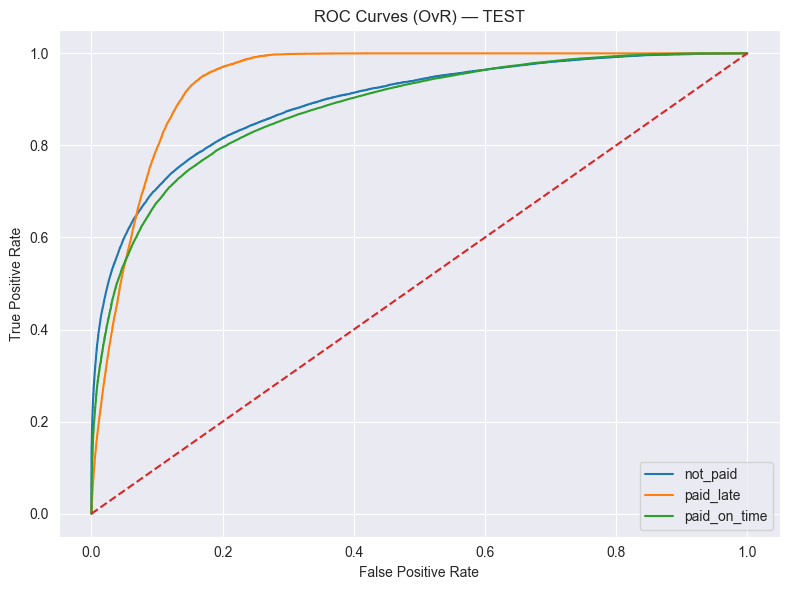

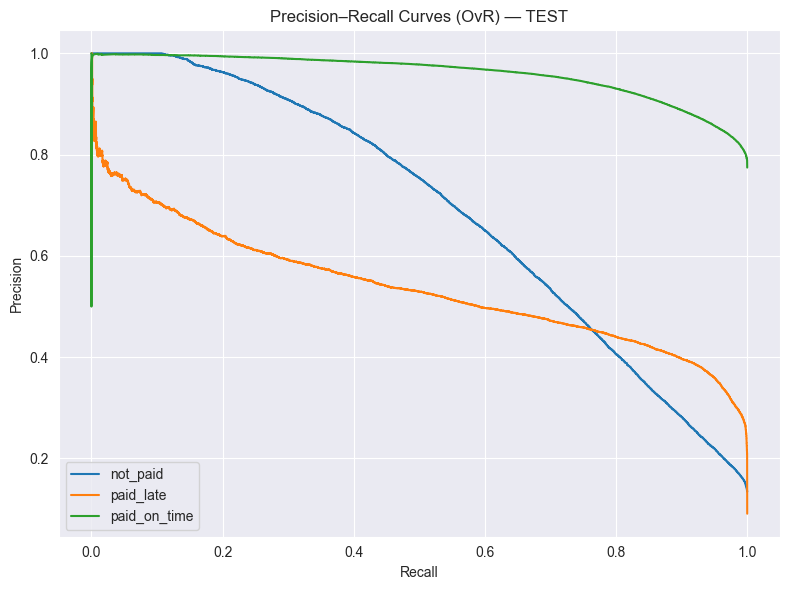

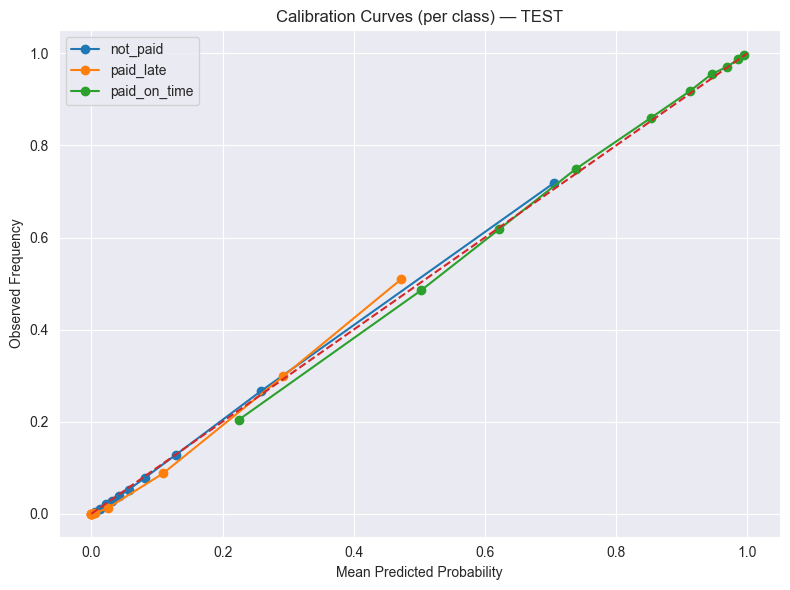

In [24]:
# Prepare DEV (train) and TEST (frozen) matrices
X_dev = df_minimal_clean_train.drop(columns=["target_3class"]).copy()
y_dev_cat = df_minimal_clean_train["target_3class"].astype("category")
class_names = list(y_dev_cat.cat.categories)
y_dev = y_dev_cat.cat.codes.to_numpy()

X_test = df_test.drop(columns=["target_3class"]).copy()
y_test_cat = pd.Categorical(df_test["target_3class"], categories=class_names)
y_test = pd.Series(y_test_cat).cat.codes.to_numpy()

K = len(class_names)

# Fit final model once on ALL dev (no extra splits)
preprocess = make_preprocess(X_dev)
model = XGBClassifier(**final_xgb_params)

pipe = Pipeline([
    ("pre", preprocess),
    ("model", model)
])

pipe.fit(X_dev, y_dev)

# Evaluate on test only
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=list(range(K)))
y_test_oh = np.eye(K)[y_test]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
    "precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
    "recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
    "f1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0),
    "precision_weighted": precision_score(y_test, y_pred, average="weighted", zero_division=0),
    "recall_weighted": recall_score(y_test, y_pred, average="weighted", zero_division=0),
    "f1_weighted": f1_score(y_test, y_pred, average="weighted", zero_division=0),
    "log_loss": log_loss(y_test, y_proba, labels=list(range(K))),
    "brier_multiclass": float(np.mean(np.sum((y_proba - y_test_oh) ** 2, axis=1))),
    "roc_auc_ovr_macro": roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro"),
    "pr_auc_macro": average_precision_score(y_test_bin, y_proba, average="macro"),
}

cm = confusion_matrix(y_test, y_pred, labels=list(range(K)))
cm_norm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

print("\n============================================================")
print("EVALUATION — FROZEN TEST SET ONLY (10%)")
print("============================================================")
print(f"Classes (order): {class_names}")
print(f"Test size: {len(df_test):,}\n")

for k in [
    "accuracy", "balanced_accuracy",
    "f1_macro", "f1_weighted",
    "roc_auc_ovr_macro", "pr_auc_macro",
    "log_loss", "brier_multiclass"
]:
    print(f"{k:22s}: {metrics[k]:.6f}")

print("\nConfusion Matrix (counts):")
print(pd.DataFrame(cm, index=class_names, columns=class_names))

print("\nConfusion Matrix (row-normalized):")
print(pd.DataFrame(cm_norm, index=class_names, columns=class_names).round(4))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4, zero_division=0))

# -----------------------
# 4) Plots: ROC, PR, Calibration (TEST)
# -----------------------
plt.figure(figsize=(8, 6))
for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (OvR) — TEST")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i, name in enumerate(class_names):
    prec, rec, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(rec, prec, label=name)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (OvR) — TEST")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i, name in enumerate(class_names):
    frac_pos, mean_pred = calibration_curve(
        y_test_bin[:, i], y_proba[:, i],
        n_bins=10, strategy="quantile"
    )
    plt.plot(mean_pred, frac_pos, marker="o", label=name)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curves (per class) — TEST")
plt.legend()
plt.tight_layout()
plt.show()

### bad loaners features ###